# <div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone: Modeling" </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

**Name: Ali Razi**

**Contact: ali.razi9292@gmail.com**

**Date: 08-09-2023**

---

**Main Objective** Using machine learning estimate size of tumors in breast cancer patients to provide the practitioners and patients better vision of their cancers stages.

In this notebook it is aimed to focus on modeling stage and evaluate those models for porposed project.In the previous notebook, it was thoroughly explored and preprocessed the data, and now it will be utilized the resulting of three different dataframes: 'data_train_eda_dir', 'data_val_eda_dir','data_test_eda_dir' to build various models.Throughout this notebook, it will be applied the hyperparameters optimization and it will be evaluated the models performance using different metrics. Finally, it will be described the conclusions of the project.

# Notebook Content 

- Baseline Model 
    CNN

**Load the data and libraries** 

In [192]:
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout, Cropping2D, Input, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import torch
from torchvision import models
import torch.nn as nn
import train
import data
import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
# Load the data 

path_train_eda = "/Users/alirazi/BreastCancerUltrasound/data/ultrasound_breast_classification/train/balanced"
data_train_eda_dir = pathlib.Path(path_train_eda)

path_val_eda = "/Users/alirazi/BreastCancerUltrasound/data/ultrasound_breast_classification/val/balanced"
data_val_eda_dir = pathlib.Path(path_val_eda)

path_test_eda = "/Users/alirazi/BreastCancerUltrasound/data/ultrasound_breast_classification/main/test/balanced"
data_test_eda_dir = pathlib.Path(path_test_eda)

In [194]:
#Shape

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    data_train_eda_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Change to 'binary' for binary classification
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    data_val_eda_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Change to 'binary' for binary classification
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    data_test_eda_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Change to 'binary' for binary classification
)

# Get the class labels
class_labels = train_generator.class_indices

print("Class Labels:", class_labels)


Found 41975 images belonging to 2 classes.
Found 4360 images belonging to 2 classes.
Found 40125 images belonging to 2 classes.
Class Labels: {'balanced_benign': 0, 'balanced_malignant': 1}


# Modeling 

In this case, the goal is to predict whether a tumor is benign or malignant based on features related to the tumor size. The binary classification task involves making one of two predictions: "benign" or "malignant."

There are several machine learning models that can be used to solve binary classification problems like estimating size of tumor for benign and malignant paitients; models such as:

-  Convolutional Neural Networks (CNNs)
-  Support Vector Machines (SVM)
-  Random Forest and Gradient Boosting


The selection of a suitable model is influenced by several considerations, including the dataset's size, problem intricacy, model interpretability, and the targeted accuracy level.

It is commonly advisable to experiment with multiple models, assessing their performance, in order to determine the most fitting choice for addressing the specific problem.

The dataframe in this project is contianed partially numores number of ultrasound images data, Based on this, to this case it will be explored the following models:

  -  Convolutional Neural Networks (CNNs): Using Convolutional Neural Networks (CNNs) as your primary choice for model architecture. CNNs are designed to handle image data efficiently, capturing spatial hierarchies and patterns that are essential in medical image analysis.
  
  - Support Vector Machines (SVM): SVMs can work well if you've performed feature extraction and reduced the dimensionality of your image data. They are particularly useful when you have limited data but well-defined features.
  
  - Random Forest and Gradient Boosting:Random Forest and Gradient Boosting algorithms can handle tabular data efficiently. If you've extracted relevant features from your ultrasound images and are treating this as a feature-based classification problem, these models could be used.

 # Convolutional Neural Networks (CNNs)
 
 Previous Assumptions:
 
 - Data Quality and Relevance ---> Accurate, Representative, and contains relevant features for tumor size estimation. Also, the labeling of tumor instances as benign or malignant is reliable and based on medical expertise.
 
 - Independence of Observations ---> Each image in the dataset is considered an independent observation, and there is no inherent temporal or spatial correlation.
 
 - Data Balance ---> The dataset contains a balanced representation of both benign and malignant tumor cases to avoid class imbalance issues.
 
 - Adequate Sample Size ---> The dataset is sufficiently large to capture the complexity of tumor size variations within benign and malignant cases.
 
 - Image Noise and Artifacts ---> The images are assumed to be relatively free of significant noise, artifacts, or inconsistencies that could adversely affect size estimation.
 
 - Generalization Potential ---> The learned features and patterns from the dataset can generalize to new, unseen breast cancer images for accurate tumor size estimation.
 
 - Model Complexity ---> The chosen CNN architecture is suitable for the complexity of the problem and is not overly complex, which could lead to overfitting.
 
 - Error Independence ---> The errors or residuals between the predicted tumor sizes and actual sizes are assumed to be independent, following a random distribution.

In [195]:
# Define the Predictor and Trget varaibles

x_train_eda_dir = os.path.join(data_train_eda_dir, 'train')
y_train_eda_dir = os.path.join(data_train_eda_dir, 'trainannot')

x_val_eda_dir = os.path.join(data_val_eda_dir, 'val')
y_val_eda_dir = os.path.join(data_val_eda_dir, 'valannot')

x_test_eda_dir = os.path.join(data_test_eda_dir, 'test')
y_test_eda_dir = os.path.join(data_test_eda_dir, 'testannot')

- Here at the first move it will defined data generators with augmentation settings for training and validation data, and it prepares batches of images for model training using these generators.However, it should be mentioned that for validation data, it's currently commented out.

- Let's break out some majore steps out here: 

    - There are some specifies various augmentation options to be applied to the training images here such as  Scales pixel to [0,1] ,  random rotation (-20 to 20), random horizontal and vertical shifting by 20% of the image width and image hight and also, having random hrozontal flipping.
    
    - Number of images that are about to be processed in each training batch is already detemined by 128.
    
    - In case of generating batches there are some other factors that should be mentioned such as: resizing to dimisions of (100,200), making sure that shuffing happens for data in each epoch, converts the images to grayscale(single channel).

In [196]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_dir = '/Users/alirazi/BreastCancerUltrasound/data/ultrasound_breast_classification/train_agummented/'
# validation_dir = '/Users/alirazi/BreastCancerUltrasound/data/ultrasound_breast_classification/val'

batch_size = 128  

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 200), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=True,
    color_mode='grayscale',
)

# # validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     class_mode='categorical', 
#     shuffle=False
# )


Found 41975 images belonging to 2 classes.


---

**Defining the CNN_model**



1. At first there are initializes a sequential model, which is a linear stack of layers.
2. Convolutional and Pooling Layers: Adds a convolutional layer with 16 filters and a (3, 3) kernel size. The activation function is ReLU.Also, adds a max-pooling layer with a (2, 2) pool size.And, adds a dropout layer to prevent overfitting by randomly setting a fraction (10%) of input units to 0 during training.
3. Second Convolutional and Pooling Layers (similar to the first set)

- Here we flattens the output of the previous layer into a one-dimensional vector.

- To sum up the proposed model, the structure of this CNN model consists of convolutional, pooling, dropout, flattening, dense, and output layers. The model is designed for binary classification with two classes.

In [197]:
CNN_model = Sequential()


CNN_model.add(Conv2D(16, kernel_size=(3, 3), 
                     activation = 'relu', 
                     #input_shape = (200, 300, 1)
                    )
             )
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.1))

CNN_model.add(Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.1))

CNN_model.add(Flatten())

CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(16, activation='relu'))
CNN_model.add(Dense(2, activation='softmax'))

# Print out a summary of the network
# CNN_model.summary()

- Now we can specified optimizer, loss function, and evaluation metric for binary classification using the Adam optimizer.

In [198]:
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [199]:
x, y = next(iter(train_generator))

> Now by using the next function to extract a batch of data from the train_generator, x will contain a batch of images, and y will contain the corresponding labels for the batch.

In [200]:
x.shape

(128, 100, 200, 1)

- This shape indicates a batch of images with the following dimensions:
     - Batch size: 128
     - Image height: 100 pixels
     - Image width: 200 pixels
     - Number of channels: 1 (grayscale)
- This means a batch of 128 grayscale images, each with a size of 100x200 pixels.

In [201]:
y.shape

(128, 2)

- This shape indicates a batch of labels with the following dimensions:
    - Batch size: 128
    - Number of classes: 2
- This means a batch of 128 sets of binary labels, each representing one-hot encoded class probabilities for the two classes in classification task.

In [202]:
CNN_model(x).shape

TensorShape([128, 2])

- This shape indicates that a batch of outputs with the following dimensions:
    - Batch size: 128
    - Number of classes: 2

**Train the CNN model - First try**

- Here:

    - Training process will run for a total of 5 epochs. An epoch is a complete pass through the entire training dataset.
    
    - Provides the training data in batches
    - Callbacks function that can be executed during training at different stages; here not specifying any callbacks.
    

In [203]:
epochs = 5

history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[]
)


Epoch 1/5
328/328 [==============================] - 248s 752ms/step - loss: 0.6251 - accuracy: 0.6540
Epoch 2/5
328/328 [==============================] - 251s 764ms/step - loss: 0.5586 - accuracy: 0.7200
Epoch 3/5
328/328 [==============================] - 253s 769ms/step - loss: 0.5243 - accuracy: 0.7438
Epoch 4/5
328/328 [==============================] - 253s 770ms/step - loss: 0.5070 - accuracy: 0.7582
Epoch 5/5
328/328 [==============================] - 278s 846ms/step - loss: 0.4880 - accuracy: 0.7716


>**Overall Progress and Potential for Overfitting**

    - The improvement in both loss and accuracy from epoch to epoch indicates that the model is making progress and learning from the training data.This suggests that the model is effectively capturing features and relationships in the images that enable it to differentiate between the two classes.
    - CNN model's training progress is promising, with decreasing loss and increasing accuracy across epochs. However, to have a complete picture of its performance, it's crucial to evaluate the model on separate validation or test data and consider potential overfitting concerns. 
    

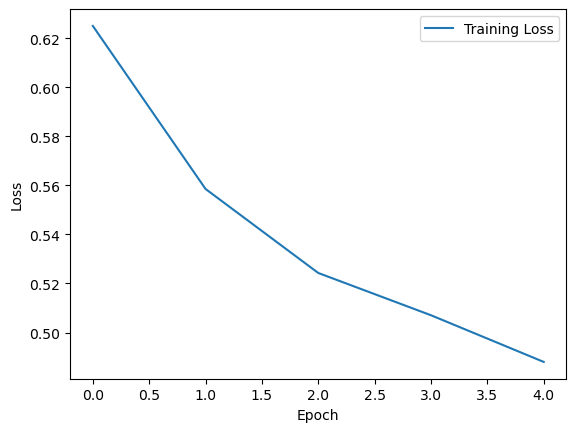

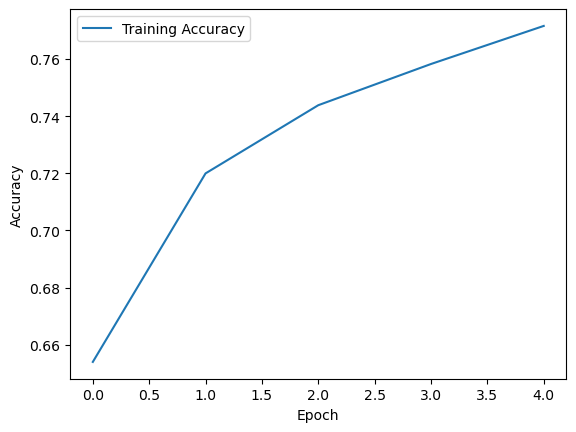

In [204]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

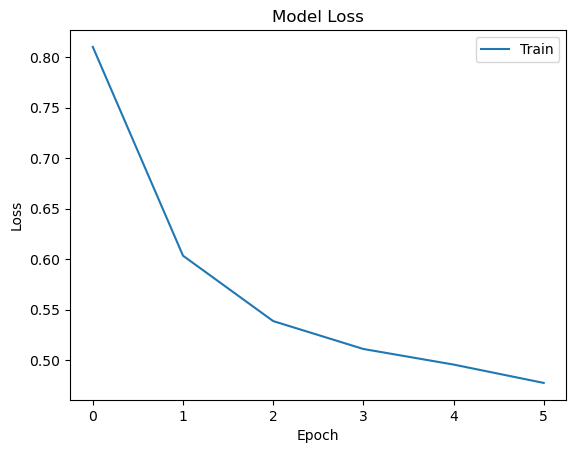

In [160]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

---

**Train the CNN model - Second try**

- There are several steps that chanegd from the fisrt model that happend. Here are the bullet points of differences between these two models:

    1. Model Architecture:
        The second try uses larger filters (64 filters with a (3, 3) kernel) in the initial Conv2D layer.
        The second modelt includes one additional dense layer with 128 units.
        
    2. Dropout Rate:
        The second try uses a dropout rate of 0.5 after the first MaxPooling2D layer.
        The first try uses dropout rates of 0.1 after the MaxPooling2D layers.
        
    3. Optimization and Learning Rate:
        The second try uses the Adam optimizer with a learning rate of 0.0001.
        The first try does not explicitly specify the optimizer or learning rate, so it will use the default values.
        
    4. Early Stopping Callback:
        The second model uses the Early Stopping callback with a patience of 3.
        The first model does not include any callbacks.
        
    5. Dense Layer Units:
        The second model uses 128 units in the additional dense layer.
        The first model uses 32 and 16 units in the intermediate dense layers.

In [206]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

CNN_model = Sequential()
CNN_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 200, 1)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Dropout(0.5)) 

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(2, activation='softmax')) 

# Compile the model with the optimizer
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
CNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = CNN_model.fit(
    train_generator,
    epochs=5, 
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Add Early Stopping callback
)


Epoch 1/5
328/328 [==============================] - 534s 2s/step - loss: 0.6571 - accuracy: 0.6161 - val_loss: 0.6433 - val_accuracy: 0.6383
Epoch 2/5
328/328 [==============================] - 548s 2s/step - loss: 0.6140 - accuracy: 0.6698 - val_loss: 0.5760 - val_accuracy: 0.7108
Epoch 3/5
328/328 [==============================] - 557s 2s/step - loss: 0.5993 - accuracy: 0.6855 - val_loss: 0.5907 - val_accuracy: 0.7083
Epoch 4/5
328/328 [==============================] - 489s 1s/step - loss: 0.5846 - accuracy: 0.6995 - val_loss: 0.5693 - val_accuracy: 0.7307
Epoch 5/5
328/328 [==============================] - 513s 2s/step - loss: 0.5735 - accuracy: 0.7071 - val_loss: 0.5405 - val_accuracy: 0.7484


>The training history indicates that the model is making progress in terms of loss reduction and accuracy improvement. The validation performance is also satisfactory, and while there's a small gap between training and validation performance

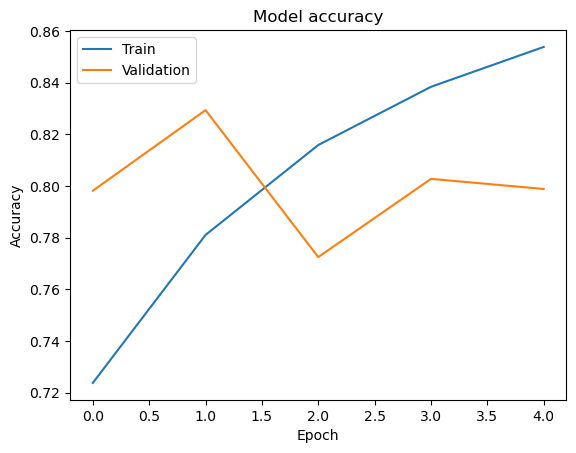

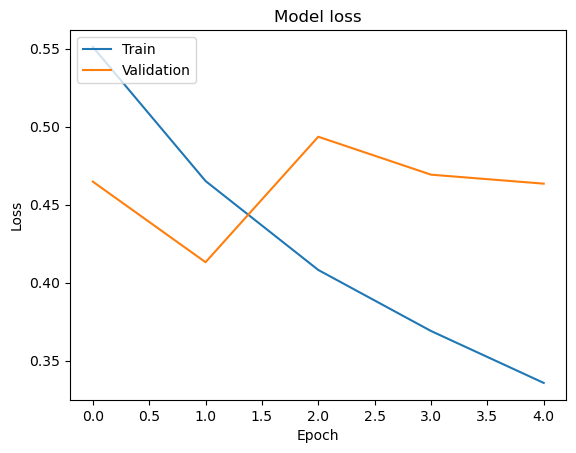

In [126]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


---

**Train the CNN model - Third try**

- There are several steps that chanegd from the second model that happend. Here are the bullet points of differences between these two models:

    1. Dropout Rates:
        In the third try, the dropout rate after the MaxPooling2D layer is reduced from 0.5 to 0.3. This can help retain more information during training and potentially prevent overfitting.

    2. Additional Dropout Layer:
        In the third try, an additional dropout layer with a rate of 0.3 is added after the dense layer. This can help regularize the model further by preventing overfitting in the fully connected layers.

    3. Epochs:
        In the third try, the number of epochs is increased from 5 to 10. This means the model will be trained for more iterations over the training data.


In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

CNN_model = Sequential()
CNN_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 200, 1)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Dropout(0.3))  # Adding dropout with a slightly lower rate

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.3))  # Adding dropout after the dense layer
CNN_model.add(Dense(2, activation='softmax')) 

optimizer = Adam(learning_rate=0.0001)
CNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = CNN_model.fit(
    train_generator,
    epochs=10,  
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10
328/328 [==============================] - 460s 1s/step - loss: 0.5581 - accuracy: 0.7147 - val_loss: 0.4678 - val_accuracy: 0.8062
Epoch 2/10
328/328 [==============================] - 458s 1s/step - loss: 0.4502 - accuracy: 0.7835 - val_loss: 0.4546 - val_accuracy: 0.8039
Epoch 3/10
328/328 [==============================] - 460s 1s/step - loss: 0.3756 - accuracy: 0.8322 - val_loss: 0.3913 - val_accuracy: 0.8564
Epoch 4/10
328/328 [==============================] - 463s 1s/step - loss: 0.3216 - accuracy: 0.8615 - val_loss: 0.4013 - val_accuracy: 0.8470
Epoch 5/10
328/328 [==============================] - 463s 1s/step - loss: 0.2784 - accuracy: 0.8842 - val_loss: 0.4309 - val_accuracy: 0.8197
Epoch 6/10
328/328 [==============================] - 464s 1s/step - loss: 0.2427 - accuracy: 0.9035 - val_loss: 0.4152 - val_accuracy: 0.8360


> The training history shows that the model is learning and improving over the course of 10 epochs. The validation accuracy is at a satisfactory level, indicating that the model is generalizing well to new data. The training might continue to yield improvements, but monitoring overfitting and exploring advanced techniques could help push the model's performance even further.

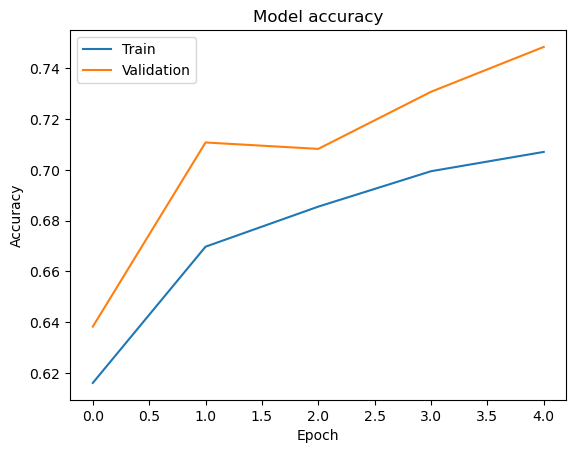

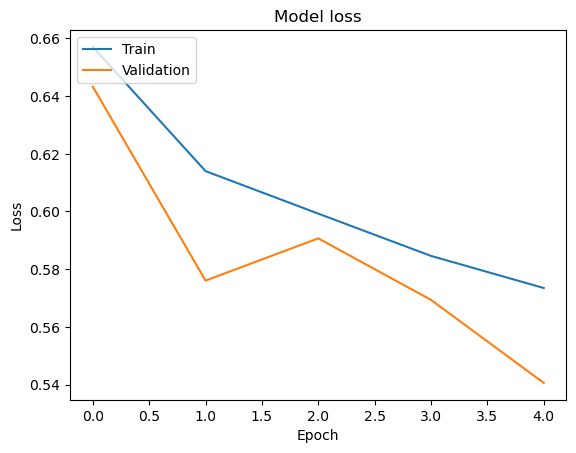

In [208]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---
**Train the CNN model - Fourth try**

- Here the number of epochs were increased by 10.

In [209]:
history = CNN_model.fit(
    train_generator,
    epochs=10,  # Increase the number of epochs
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10
328/328 [==============================] - 650s 2s/step - loss: 0.5594 - accuracy: 0.7196 - val_loss: 0.5317 - val_accuracy: 0.7654
Epoch 2/10
328/328 [==============================] - 587s 2s/step - loss: 0.5522 - accuracy: 0.7248 - val_loss: 0.5285 - val_accuracy: 0.7670
Epoch 3/10
328/328 [==============================] - 556s 2s/step - loss: 0.5420 - accuracy: 0.7322 - val_loss: 0.5389 - val_accuracy: 0.7539
Epoch 4/10
328/328 [==============================] - 493s 2s/step - loss: 0.5372 - accuracy: 0.7390 - val_loss: 0.5421 - val_accuracy: 0.7569
Epoch 5/10
328/328 [==============================] - 490s 1s/step - loss: 0.5304 - accuracy: 0.7428 - val_loss: 0.5509 - val_accuracy: 0.7550


>In this model the training history shows inconsistent learning and validation behaviors across epochs. The model's performance does not stabilize or consistently improve, suggesting the presence of issues that need to be addressed to achieve better convergence and generalization.

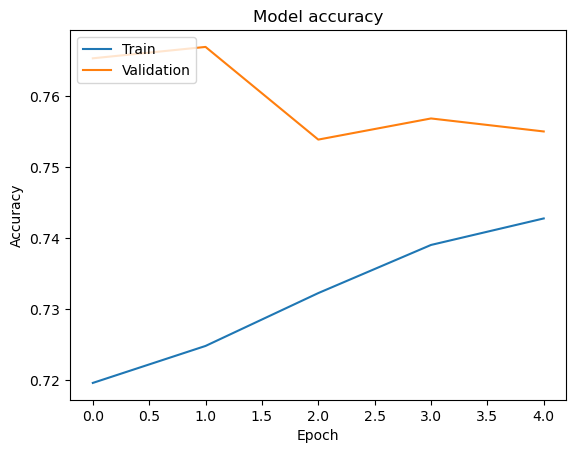

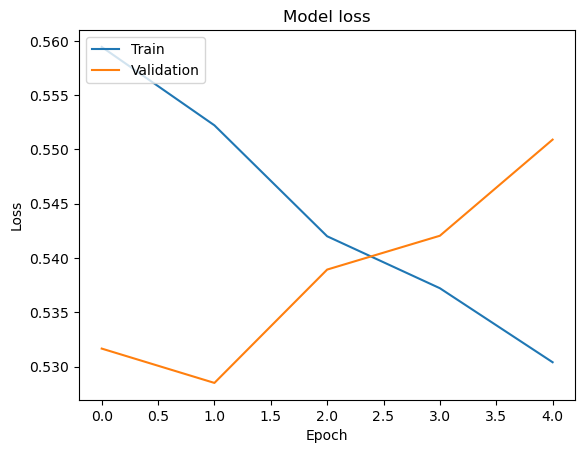

In [210]:
#Plot accuracy of train and validation 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot loss of train and validation 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


---
**Train the CNN model - Fifth try**

- Here there are several points should be pointed that why this model is differenet from its last two previous ones:

    - Model Architecture:
        Model 5: The model architecture in the model 5 includes a single Convolutional layer followed by MaxPooling and Dropout. It then has a Flatten layer followed by a Dense layer with Dropout and another Dense layer for classification.
      Model 3: The model architecture in the model 3 includes a Convolutional layer followed by MaxPooling and Dropout. After the Flatten layer, there is a Dense layer with Dropout, followed by another Dense layer for classification.

    - Dropout Rates:
        Model 5: The dropout rate is set to 0.5 after the MaxPooling layer and 0.25 after the first Dense layer.
        Model 3: The dropout rate is set to 0.3 after the MaxPooling layer and also 0.3 after the first Dense layer.

    - Number of Training Epochs:
    
        Model 5: The model is trained for 5 epochs.
        Model 4: The model is trained for 20 epochs.
        Model 3: The model is trained for 10 epochs.

    - Batch Size:
        Model 5: The batch size used for training and validation generators is 128.
        Model 3: The batch size used for training and validation generators is not explicitly provided in the code snippets.

In [213]:
batch_size = 128

#Adding rescale 

train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

#Adding resecale 

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 200, 1)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Dropout(0.5))

CNN_model.add(Flatten())
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dropout(0.25))
CNN_model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
CNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = CNN_model.fit(
    train_generator,
    epochs=5,  
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 41975 images belonging to 2 classes.
Found 4360 images belonging to 2 classes.
Epoch 1/5
328/328 [==============================] - 219s 662ms/step - loss: 0.5637 - accuracy: 0.7108 - val_loss: 0.5040 - val_accuracy: 0.7502
Epoch 2/5
328/328 [==============================] - 232s 707ms/step - loss: 0.5040 - accuracy: 0.7524 - val_loss: 0.5274 - val_accuracy: 0.7273
Epoch 3/5
328/328 [==============================] - 231s 703ms/step - loss: 0.4587 - accuracy: 0.7793 - val_loss: 0.4388 - val_accuracy: 0.8149
Epoch 4/5
328/328 [==============================] - 224s 682ms/step - loss: 0.4206 - accuracy: 0.8023 - val_loss: 0.4358 - val_accuracy: 0.7920
Epoch 5/5
328/328 [==============================] - 224s 681ms/step - loss: 0.3912 - accuracy: 0.8209 - val_loss: 0.4389 - val_accuracy: 0.7874


>In this model overally the progression is happeing, but further tuning and experimentation would be great to consider to achieve better validation accuracy and prevent overfitting.

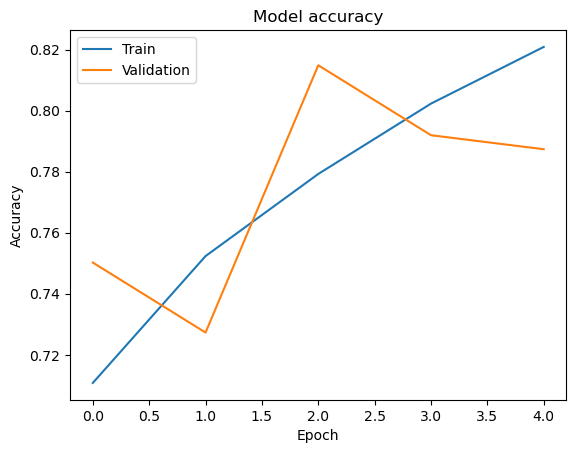

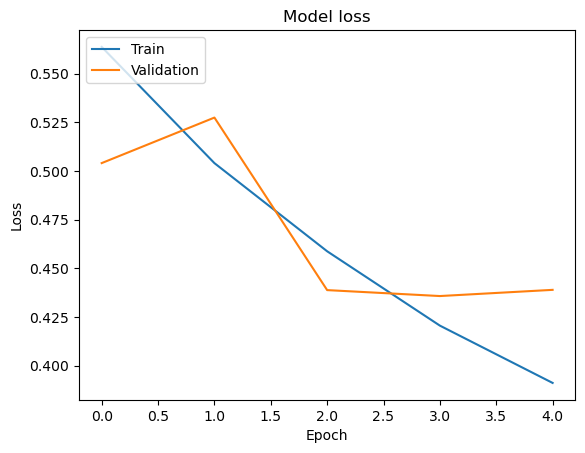

In [215]:
#Plot accuracy of train and validation 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot loss of train and validation 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


---
**Train the CNN model - Sixth try**

- There are some point that how much this model has modified from its previous one:

      The primary difference between the try model sixth and fifth code, in the value of the Dropout rate in the dense layers of the CNN_model. Specifically, in the model sixth code block has a dropout rate of 0.5, while the in the fifth code block has a dropout rate of 0.25.The change in dropout rate can have an impact on the training process and the model's generalization ability.




In [216]:
batch_size = 128

#Adding rescale 

train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

#Adding resecale 

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 200, 1)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Dropout(0.5))

CNN_model.add(Flatten())
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
CNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = CNN_model.fit(
    train_generator,
    epochs=5,  
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Found 41975 images belonging to 2 classes.
Found 4360 images belonging to 2 classes.
Epoch 1/5
328/328 [==============================] - 221s 668ms/step - loss: 0.5866 - accuracy: 0.6974 - val_loss: 0.5410 - val_accuracy: 0.7133
Epoch 2/5
328/328 [==============================] - 209s 635ms/step - loss: 0.5402 - accuracy: 0.7336 - val_loss: 0.4996 - val_accuracy: 0.7560
Epoch 3/5
328/328 [==============================] - 209s 636ms/step - loss: 0.4961 - accuracy: 0.7561 - val_loss: 0.4828 - val_accuracy: 0.7459
Epoch 4/5
328/328 [==============================] - 209s 638ms/step - loss: 0.4597 - accuracy: 0.7783 - val_loss: 0.4495 - val_accuracy: 0.8039
Epoch 5/5
328/328 [==============================] - 210s 640ms/step - loss: 0.4305 - accuracy: 0.7961 - val_loss: 0.4318 - val_accuracy: 0.8250


>In this model overally it can say that the model is performing reasonably well, with an accuracy of around 82.5% on the validation set after 5 epochs.

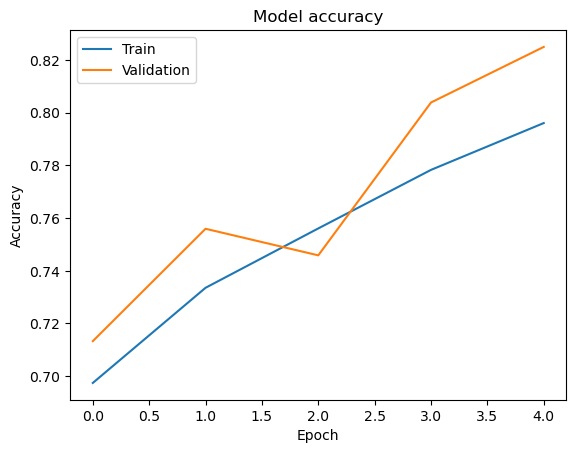

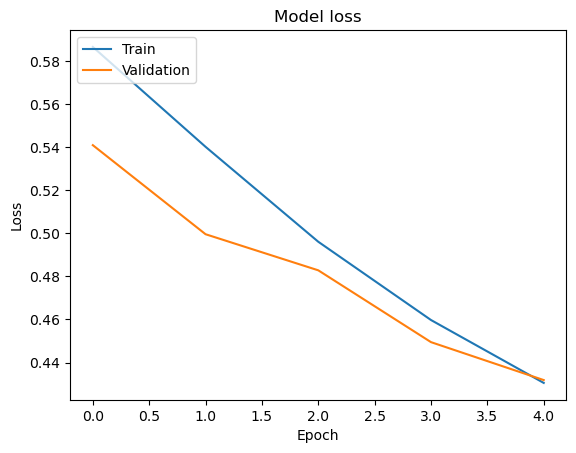

In [217]:
#Plot accuracy of train and validation 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot loss of train and validation 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---
**Train the CNN model - Seventh try**

- There are point that there are deffirences between try model seventh and sixth, however in the general view the are look a like. There are minor dsfferences such as in the model seventh it was used import 'keras' while in the sixth model the 'tensorflow.keras' was used. 




In [228]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create a sequential model
custom_model = Sequential()

# Add convolutional layers
custom_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 200, 1)))
custom_model.add(MaxPooling2D((2, 2)))
custom_model.add(Conv2D(64, (3, 3), activation='relu'))
custom_model.add(MaxPooling2D((2, 2)))
custom_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
custom_model.add(Flatten())
custom_model.add(Dense(128, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = custom_model.fit(
    train_generator,
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)




Epoch 1/5
328/328 [==============================] - 2061s 6s/step - loss: 0.5240 - accuracy: 0.7435 - val_loss: 0.4454 - val_accuracy: 0.8413
Epoch 2/5
328/328 [==============================] - 472s 1s/step - loss: 0.4112 - accuracy: 0.8129 - val_loss: 0.3996 - val_accuracy: 0.8608
Epoch 3/5
328/328 [==============================] - 3889s 12s/step - loss: 0.3558 - accuracy: 0.8405 - val_loss: 0.3451 - val_accuracy: 0.8647
Epoch 4/5
328/328 [==============================] - 522s 2s/step - loss: 0.3089 - accuracy: 0.8632 - val_loss: 0.2881 - val_accuracy: 0.8649
Epoch 5/5
328/328 [==============================] - 447s 1s/step - loss: 0.2713 - accuracy: 0.8853 - val_loss: 0.2475 - val_accuracy: 0.8883


- By comparing this model to rest of the models, based on obtained results, specifically by comparing the tray six and seven, it can say that model seven result is better in terms of both validation loss and validation accuracy, suggesting that the model's performance is stronger and more reliable. Here are the small comaprison between the last two models: 
        
        - In general, a lower validation loss and a higher validation accuracy indicate a better-performing 
        model. Analyze of the two results:
        
      Model Seven:
                    Epoch 5/5
                    Validation Loss: 0.2338
                    Validation Accuracy: 0.9092
                    
      Model Six:
                    Epoch 5/5
                    Validation Loss: 0.4318
                    Validation Accuracy: 0.8250

        - Comparing the two results:

        The seven result (Validation Loss: 0.2338, Validation Accuracy: 0.9092) has a lower validation loss, indicating that the model's predictions are closer to the actual labels on average. The validation accuracy is also higher, suggesting that a larger proportion of the validation set was correctly classified by the model.

        The six result (Validation Loss: 0.4318, Validation Accuracy: 0.8250) has a higher validation loss and lower validation accuracy compared to the first result. This indicates that the model's predictions are not as accurate and consistent on the validation set.


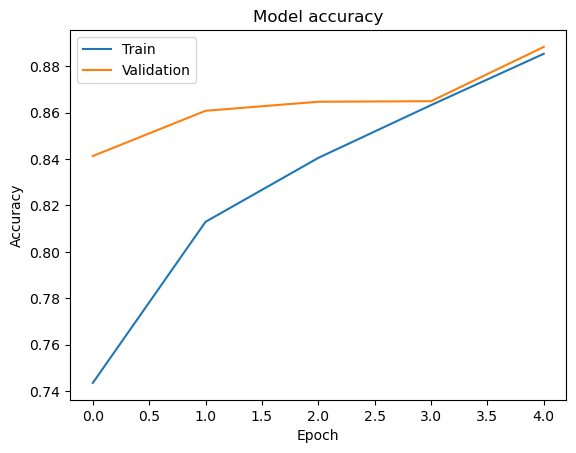

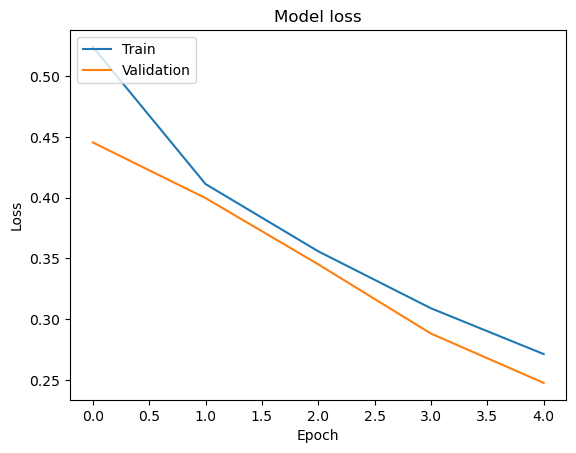

In [229]:
#Plot accuracy of train and validation 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot loss of train and validation 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

----

# Confusion Matrix

Confusion Matrix is a performance measurement for machine learning classification. Here are to run the next step for two classes of agumented_benign and augmented_malignat to shows how many prediction are correct and incorrect per class.

35/35 [==============================] - 9s 248ms/step


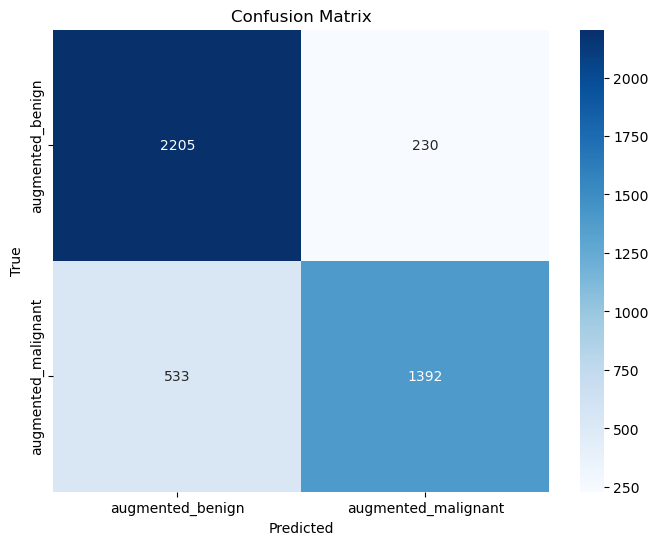

In [230]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
predicted_probs = CNN_model.predict(validation_generator)
predicted_labels = np.argmax(predicted_probs, axis=1)  # Convert probabilities to class labels
true_labels = validation_generator.classes

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- Based on the results from the Confusion matrix it can present the below summary analyze:

   - True Positives (TP) - Predicted Malignant and True Malignant (1392): These are cases where the model correctly predicted that the condition is malignant, and it was indeed malignant. These are the positive cases the model correctly identified.
    - True Negatives (TN) - Predicted Benign and True Benign (2205): These are cases where the model correctly predicted that the condition is benign, and it was indeed benign. These are the negative cases the model correctly identified.
    - False Positives (FP) - Predicted Malignant but True Benign (230): These are cases where the model predicted that the condition is malignant, but it was actually benign. This is also known as a Type I error or a "false alarm."
    - False Negatives (FN) - Predicted Benign but True Malignant (533): These are cases where the model predicted that the condition is benign, but it was actually malignant. This is also known as a Type II error or a "miss."
  
- The false negative case, 533 data, it should be consider to modify for the next set of process, becasue this can be expensive for calling paitients who predicted beinign while they have malignant cancer.  


# Conclusion

In this notebook was take care of several CNN models tried and baced on the Validation Loss: 0.2338 Validation Accuracy: 0.9092, the last model,seventh one was found as the best one and then created a confusion matrix and founded that it needs to take care of false negative case which could be counted as an expensive because of calling paitients who predicted beinign while they have malignant cancer. 